interactive(children=(FloatSlider(value=5.0, description='tf', max=20.0, min=1.0), FloatSlider(value=0.0, desc…

<function __main__.interactive_plot(tf, aileron, elevator)>

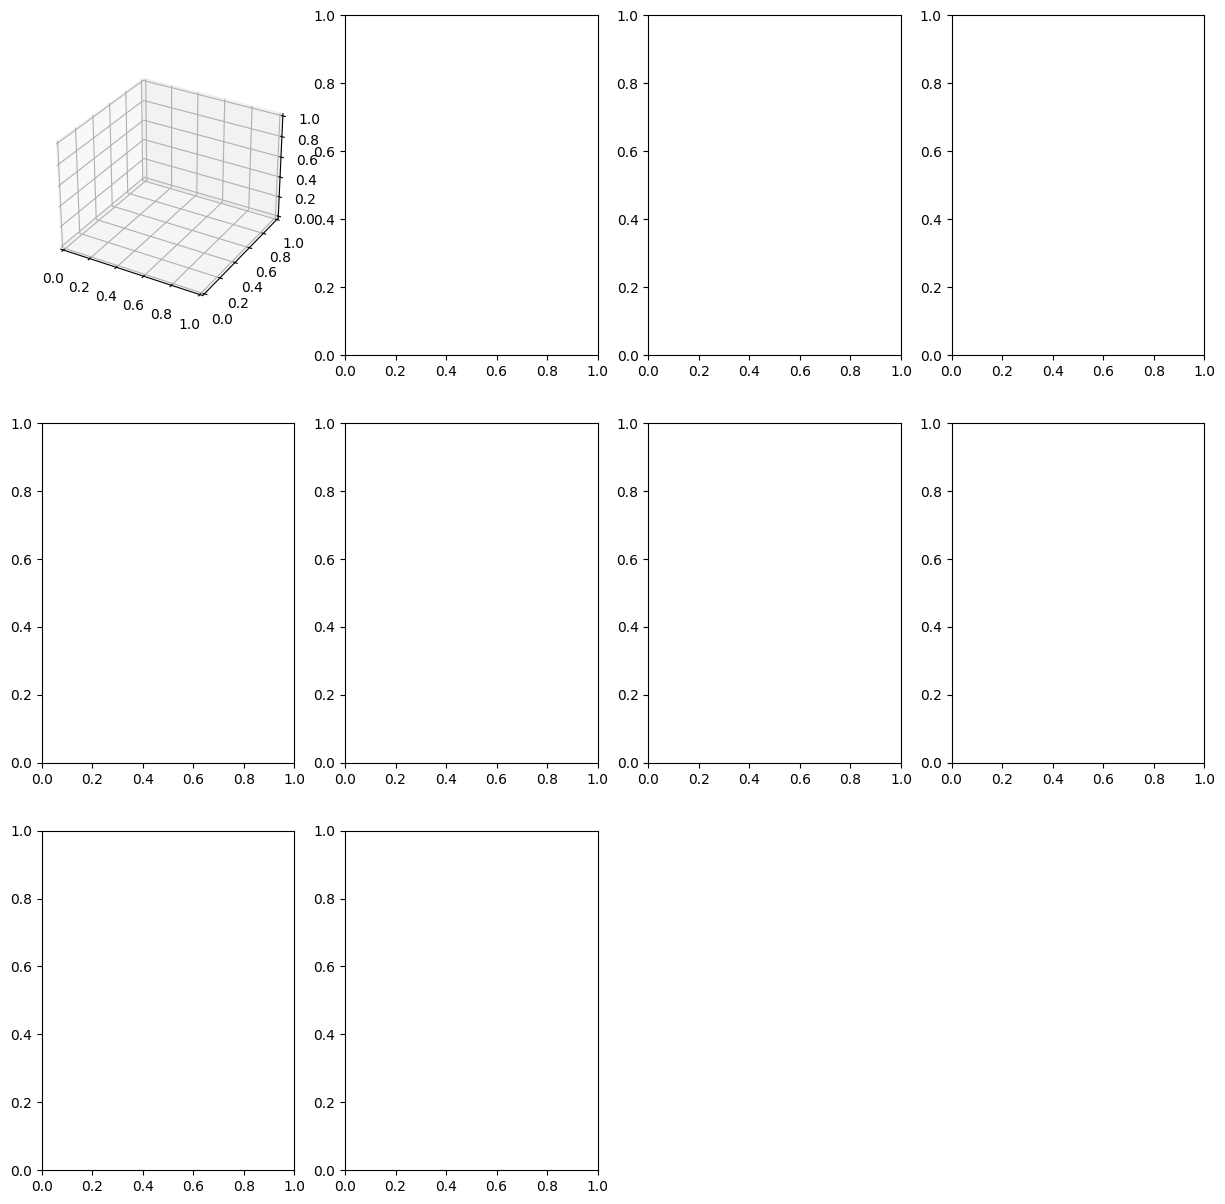

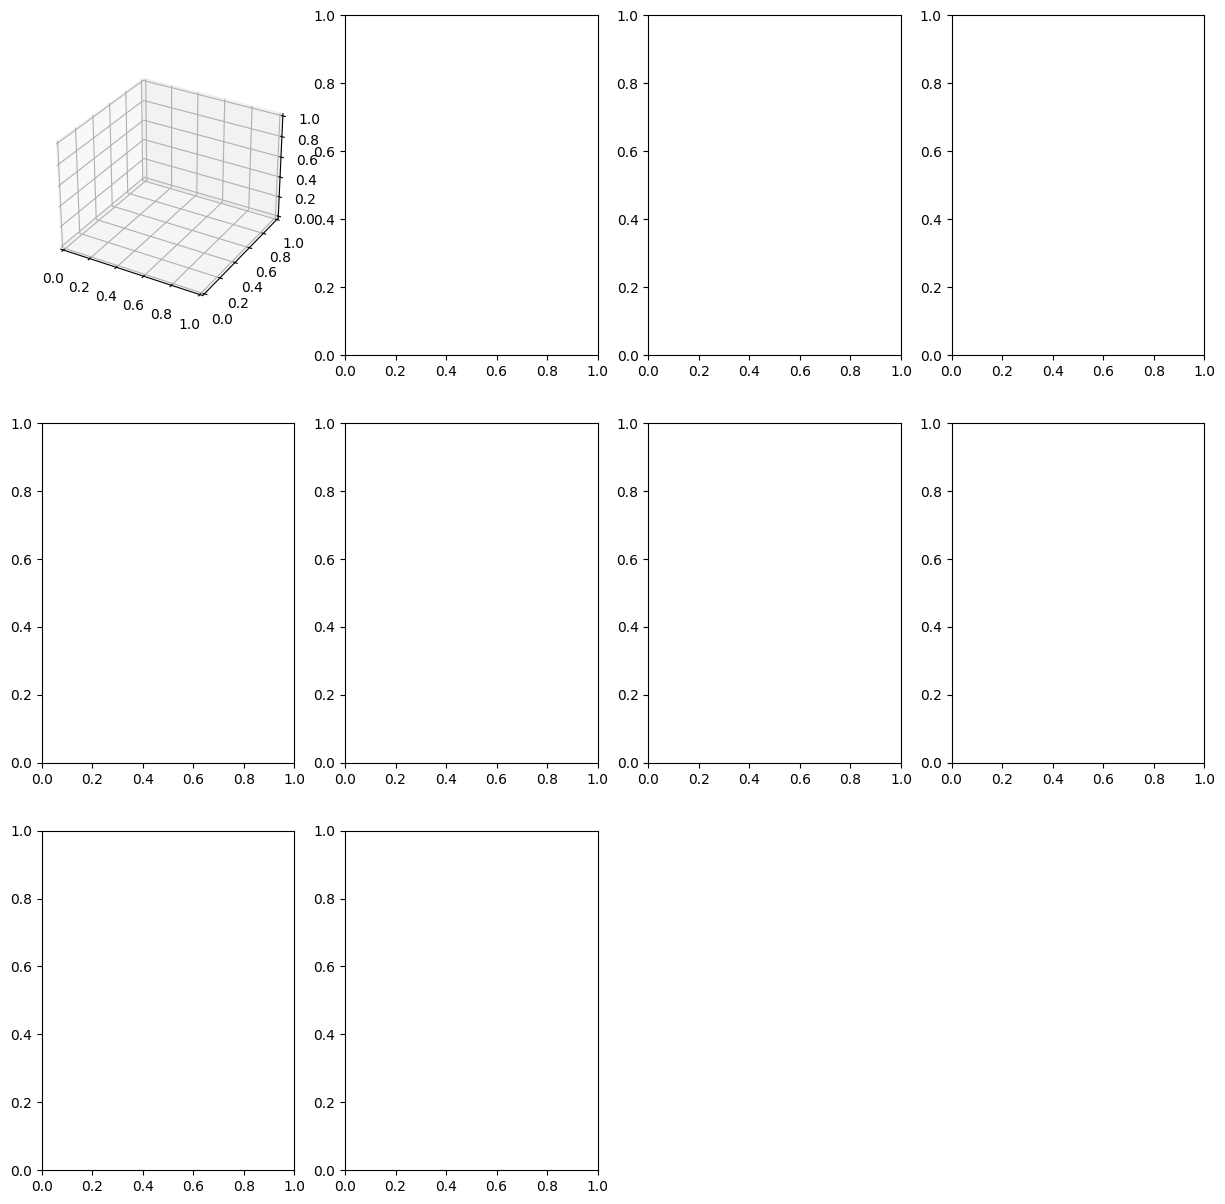

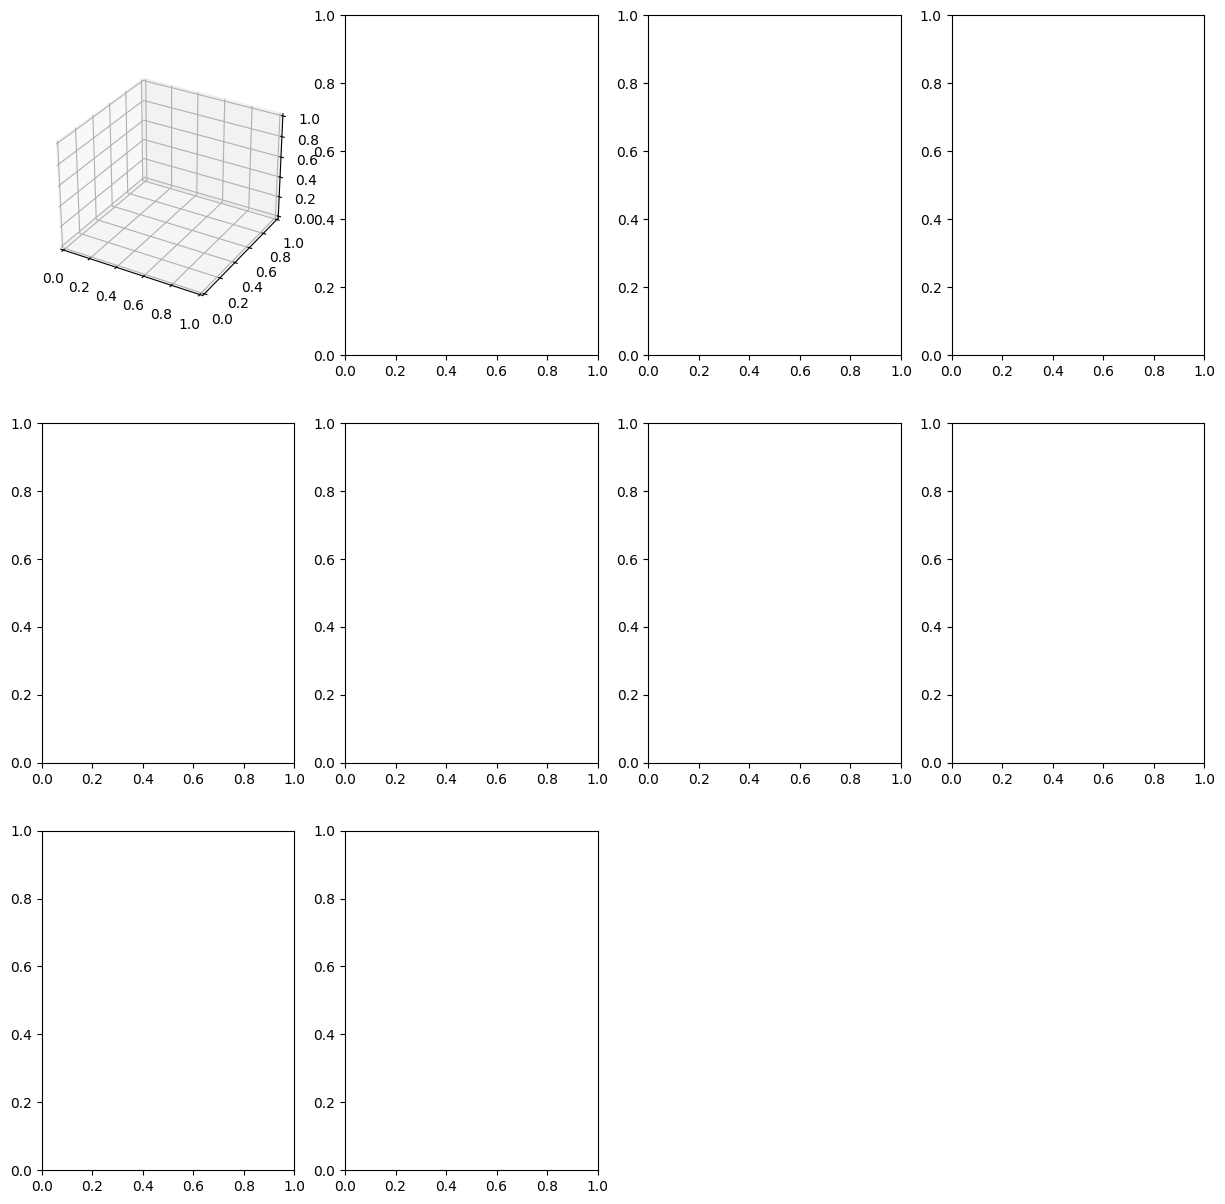

In [ ]:
import json
import os
import numpy as np
import casadi as ca
import h5py
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
import ipywidgets as widgets
from ipywidgets import interact
from IPython.display import display

from dynamics_minimal import Aircraft, AircraftOpts, TrajectoryConfiguration
from utils import load_model
from liecasadi import Quaternion
from plotting import TrajectoryPlotter

%matplotlib inline


# Load required modules and configurations
model = load_model()
traj_dict = json.load(open('../data/glider/problem_definition.json'))
trajectory_config = TrajectoryConfiguration(traj_dict)
aircraft_config = trajectory_config.aircraft

poly_path = Path("../main/fitted_models_casadi.pkl")
opts = AircraftOpts(poly_path=poly_path, aircraft_config=aircraft_config)
aircraft = Aircraft(opts=opts)



# Function to run the simulation
def simulate_trajectory(tf, aileron, elevator, plotter):
    dt = 0.1
    num_steps = int(tf / dt)

    # Initial conditions
    x0 = np.zeros(3)
    v0 = ca.vertcat([80, 0, 0])
    q0 = Quaternion(ca.vertcat(0, 0, 0, 1))
    omega0 = np.array([0, 0, 0])

    state = ca.vertcat(q0, x0, v0, omega0)
    control = np.zeros(aircraft.num_controls)
    control[0] = aileron  # Aileron deflection
    control[1] = elevator  # Elevator deflection

    dyn = aircraft.state_update
    state_list = np.zeros((aircraft.num_states, num_steps))
    control_list = np.zeros((aircraft.num_controls, num_steps))

    for i in tqdm(range(num_steps), desc="Simulating Trajectory"):
        if np.isnan(state[0]):
            print("Aircraft crashed!")
            break
        elif np.linalg.norm(state[0:4]) > 1000:
            print("Aircraft crashed!")
            break
        else:
            state_list[:, i] = state.full().flatten()
            control_list[:, i] = control
            state = dyn(state, control, dt)

    # Save trajectory data
    filepath = os.path.join("../data", "trajectories", "simulation.h5")
    if os.path.exists(filepath):
        os.remove(filepath)

    with h5py.File(filepath, "a") as h5file:
        grp = h5file.create_group(f'iteration_0')
        grp.create_dataset('state', data=state_list[:, :i + 1])
        grp.create_dataset('control', data=control_list[:, :i + 1])

    # Plot the results
    plotter = TrajectoryPlotter(aircraft)
    plotter.plot(filepath=filepath)
    plt.show()

# Interactive widgets
tf_widget = widgets.FloatSlider(value=5.0, min=1.0, max=20.0, step=0.1, description='Final Time (s)')
aileron_widget = widgets.FloatSlider(value=2.0, min=-5.0, max=5.0, step=0.1, description='Aileron (deg)')
elevator_widget = widgets.FloatSlider(value=2.0, min=-5.0, max=5.0, step=0.1, description='Elevator (deg)')
simulate_button = widgets.Button(description="Run Simulation")

# # Callback to run simulation
# def on_simulate_click(change):
#     simulate_trajectory(tf_widget.value, aileron_widget.value, elevator_widget.value, plotter=plotter)

# simulate_button.on_click(on_simulate_click)

# # Display the widgets
# display(tf_widget, aileron_widget, elevator_widget, simulate_button)

def interactive_plot(tf, aileron, elevator):
    simulate_trajectory(tf, aileron, elevator, plotter)

interact(
    interactive_plot, 
    tf=widgets.FloatSlider(min=1.0, max=20.0, step=0.1, value=5.0),
    aileron=widgets.FloatSlider(min=-5, max=5.0, step=0.1, value=0.0),
    elevator=widgets.FloatSlider(min=-5.0, max=5.0, step=0.1, value=0.0)
)


In [2]:
pip install ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 5.7 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.
